# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim_supervised.ipynb`


## Organization of the Notebook

- Set up database of data sets
- Application of different pre-treatments (including BinSim) to each data set
- **Random Forest - optimization, predictive accuracy and important features: comparison after aplication of different pre-treatment procedures**
- **PLS-DA - optimization, predictive accuracy and important features: comparison after aplication of different pre-treatment procedures**

Generation of Random Forest and PLS-DA models will only be performed if `GENERATE = True` in the cells before application of each one.

Furthermore, pre-processed datasets are loaded from json and hdf storages present in folder `paperimages`. These were created by notebook `paper_binsim_data_prep.ipynb`.

Given the randomness of CV-folds the results may vary slightly from those presented in the paper.

#### Needed Imports

In [1]:
import itertools
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `Ionly`: missing value imputed data, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD 2/15)
- YD2 (YD 6/15)
- vitis_types (GD types)

### Description of grapevine data sets

Grapevine Datasets (Negative and Positive) - 33 samples belonging to 11 different grapevine varieties (3 samples per variety/biological group) of FT-ICR-MS metabolomics data obtained in negative and positive ionization mode.

5 different _Vitis_ species (other than _V. vinifera_) varieties:

- CAN - 3 Samples (14, 15, 16) of _V. candicans Engelmann_ (VIVC variety number: 13508)
- RIP - 3 Samples (17, 18, 19) of _V. riparia Michaux_ (Riparia Gloire de Montpellier, VIVC variety number: 4824) 
- ROT - 3 Samples (20, 21, 22) of _V. rotundifolia_ (Muscadinia Rotundifolia Michaux cv. Rotundifolia, VIVC variety number: 13586)
- RU - 3 Samples (35, 36, 37) of _V. rupestris Scheele_ (Rupestris du lot, VIVC variety number: 10389)
- LAB - 3 Samples (8, 9, 10) of _V. labrusca_ (Isabella, VIVC variety number: 5560)

6 different _V. vinifera_ cultivars varieties are:

- SYL - 3 samples (11, 12, 13) of the subspecies _sylvestris_ (VIVC variety number: -)
- CS - 3 Samples (29, 30, 31) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 1929)
- PN - 3 Samples (23, 24, 25) of the subspecies _sativa_ cultivar Pinot Noir (VIVC variety number: 9279)
- REG - 3 Samples (38, 39, 40) of the subspecies _sativa_ cultivar Regent (VIVC variety number: 4572)
- RL - 3 Samples (26, 27, 28) of the subspecies _sativa_ cultivar Riesling Weiss (VIVC variety number: 10077)
- TRI - 3 Samples (32, 33, 34) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 15685)

References for these data:

- Maia M, Ferreira AEN, Nascimento R, et al. Integrating metabolomics and targeted gene expression to uncover potential biomarkers of fungal / oomycetes ‑ associated disease susceptibility in grapevine. Sci Rep. Published online 2020:1-15. doi:10.1038/s41598-020-72781-2
- Maia M, Figueiredo A, Silva MS, Ferreira A. Grapevine untargeted metabolomics to uncover potential biomarkers of fungal/oomycetes-associated diseases. 2020. doi:10.6084/m9.figshare.12357314.v1

**Peak Alignment** and **Peak Filtering** were performed with function `metabolinks.peak_alignment.align()`. Human leucine enkephalin (Sigma Aldrich) was used as the reference feature (internal standard, [M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da).

**4** data matrices were constructed from this data:

- Data sets named `GD_pos_global2` (GDg2+) and `GD_neg_global2` (GDg2-) were generated after retaining only features that occur (globally) at least twice in all 33 samples of the data sets (filtering/alignment) for the **positive mode** data acquisition and the **negative mode** data acquisition, respectively.
- Data sets named `GD_pos_class2` (GDc2+) and `GD_neg_class2` (GDc2-) were generated after retaining only features that occur at least twice in the three replicates of at least one _Vitis_ variety in the data sets (filtering/alignment) for the **positive mode** data acquisition and the **negative mode** data acquisition, respectively.

For the purpose of assessing the performance of supervised methods each of these four datasets was used with target labels defining classes corresponding to replicates of each of the 11 Vitis species/cultivars.

For the purpose of assessing the performance of supervised methods under a binary (two-class) problem, data set `GD_neg_class2` was also used with target labels defining two classes: Vitis vinifera cultivars and "wild", non-vinifera Vitis species. This is dataset `vitis_types` (GD types).

### Description of the yeast data set

Yeast dataset - 15 samples belonging to 5 different yeast strains of _Saccharomyces cerevisiae_ (3 biological replicates per strain/biological group) of FT-ICR-MS metabolomics data obtained in positive ionization mode. The 5 strains were: the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1 (GLO1), ΔGLO2 (GLO2), ΔGRE3 (GRE3) and ΔENO1 (ENO1). These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Reference for this data:

- Luz J, Pendão AS, Silva MS, Cordeiro C. FT-ICR-MS based untargeted metabolomics for the discrimination of yeast mutants. 2021. doi:10.6084/m9.figshare.15173559.v1

**Peak Alignment** and **Peak Filtering** was performed with MetaboScape 4.0 software (see reference above for details in sample preparation, pre-processing, formula assignment). In short, Yeast Dataset was obtained with Electrospray Ionization in Positive Mode and pre-processed by MetaboScape 4.0 (Bruker Daltonics). Human leucine enkephalin (Sigma Aldrich) was used as the reference feature (internal standard, [M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da).

**2** data matrices were constructed from this data:

- Data set named `YD` (YD 2/15) was generated after retaining only features that occur (globally) at least twice in all 15 samples (filtering/alignment).
- Data set named `YD2` (YD 6/15) was generated after retaining only features that occur (globally) at least six times in all 15 samples (filtering/alignment).

For the purpose of assessing the performance of supervised methods, this data set was used with target labels defining classes corresponding to replicates of each of the 4 yeast strains.

## Load datasets

In [3]:
path = Path.cwd() / "paperimages" / 'processed_data.json'
storepath = Path.cwd() / "paperimages" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]

## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5-fold cross-validation in `vitis_types`).

Each method will be applied to the 4 differently-treated data sets (P, NP, NGP and BinSim) for each of the 7 benchmark data sets.

**Note**: If `Generate` is **True**, Random Forest and PLS-DA will be applied. They are always on the cell before the application.

## Random Forests

In [4]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

#### ROC curves

ROC curves are computed for the `vitis_types` classifier only (2-class problem) using `RandomForestClassifier` from scikit-learn in the function `RF_ROC_cv` from multianalysis.py.

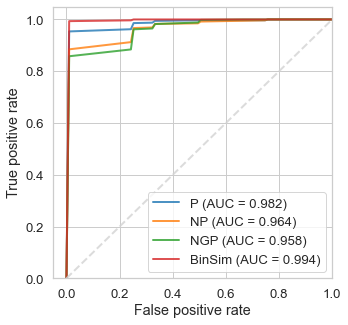

In [5]:
np.random.seed(16)
name = 'vitis_types'
pos_label = 'vinifera'
dataset = datasets[name]
y = dataset['target']
resROC = {}
for treatment in ('P', 'NP', 'NGP', 'BinSim'):
    df = dataset[treatment]
    res = ma.RF_ROC_cv(df, y, pos_label, n_fold=5, n_trees=20, n_iter=20)
    resROC[treatment] = res

p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(5,5))
        for treatment, color in zip(resROC, p4):
            res = resROC[treatment]
            mean_fpr = res['average fpr']
            mean_tpr = res['average tpr']
            mean_auc = res['mean AUC']
            ax.plot(mean_fpr, mean_tpr, color=color,
                   label=f'{treatment} (AUC = {mean_auc:.3f})',
                   lw=2, alpha=0.8)
        
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
        ax.legend()
        ax.set_xlim(None,1)
        ax.set_ylim(0,None)
        ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
              # title="Random forest ROC curves for Vitis types data set")
        plt.show()
        f.savefig('paperimages/ROC_vitis.pdf', dpi=200)
        f.savefig('paperimages/ROC_vitis.png', dpi=600)

### Optimization of the number of trees

Random Forest models with different number of trees are built to assess when the predictive accuracy of the different models stops increasing with the number of trees. Grid search of number of trees from 10 to 100 for the random forests with 5 tree interval. See where the cross-validation estimated predictive accuracy stops improving for each one.

In [6]:
GENERATE = False

In [7]:
if GENERATE:
    # NOTE: for debugging
    top_tree_in_grid=100
    # otherwise
    #top_tree_in_grid=200

    # Vector with values for the parameter n_estimators
    # Models will be built from 10 to top_tree_in_grid trees in 5 tree intervals
    values = {'n_estimators': range(10,top_tree_in_grid,5)}

    rf = skensemble.RandomForestClassifier(n_estimators=200)
    clf = GridSearchCV(rf, values, cv=3)
    clf_2class = GridSearchCV(rf, values, cv=5)

    # For each dataset, build  Random Forest models with the different number of trees
    # and store the predictive accuracy (estimated by k-fold cross-validation)

    RF_optim = {}
    for name, dataset in datasets.items():
        for treatment in ('P', 'NP', 'NGP', 'BinSim'):
            print('Fitting', name, treatment, '...', end=' ')
            rfname = name + ' ' + treatment
            RF_optim[rfname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}

            if name == 'vitis_types':
                clf2use = clf_2class
            else:
                clf2use = clf
            clf2use.fit(dataset[treatment], dataset['target'])
            
            RF_optim[rfname]['scores'] = list(clf2use.cv_results_['mean_test_score'])
            RF_optim[rfname]['n_trees'] = list(clf2use.cv_results_['param_n_estimators'])

            print('Done!')
    print('writing results to file')
    path = Path.cwd() / 'paperimages' / 'RF_optim.json'
    print(path.name)
    with open(path, "w", encoding='utf8') as write_file:
        json.dump(RF_optim, write_file)

In [8]:
path = Path.cwd() / 'paperimages' / 'RF_optim.json'
with open(path, "r", encoding='utf8') as read_file:
    RF_optim = json.load(read_file)

#### Plots of tree number optimization

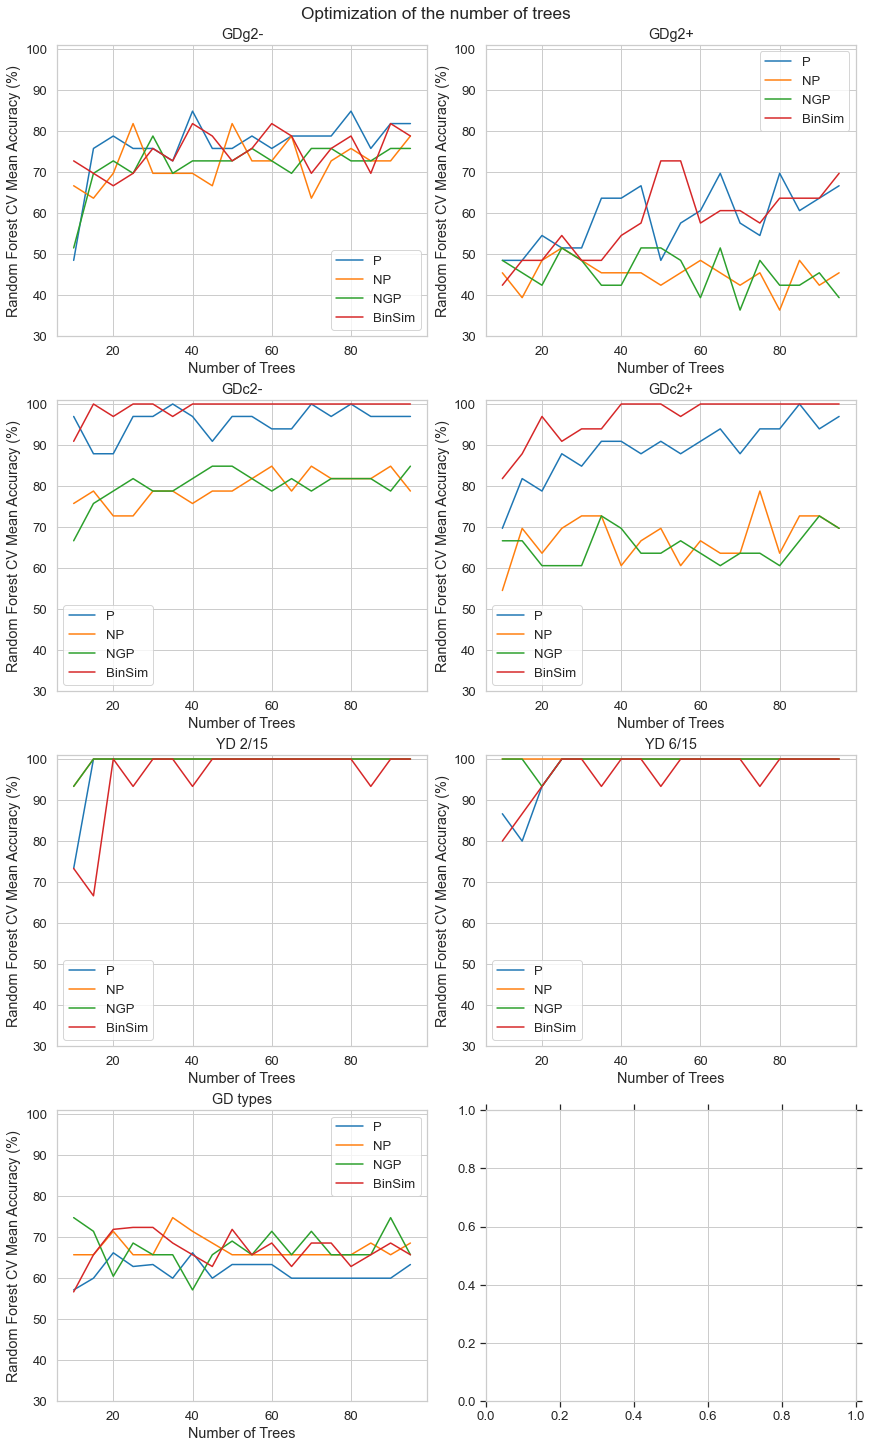

In [9]:
# Plotting the results and adjusting parameters of the plot

def plot_RF_otimization_ntrees(RF_optim, dskey, ax=None, ylabel='', title='', ylim=(30,101)):
    to_plot = [optim for key, optim in RF_optim.items() if optim['dskey'] == dskey]
    treatments = ('P', 'NP', 'NGP', 'BinSim')
    if ax is None:
        ax = plt.gca()
    for treatment in treatments:
        for optim in to_plot:
            if optim['treatment'] == treatment:
                break
        ax.plot(optim['n_trees'], [s*100 for s in optim['scores']], label=treatment)
    ax.set(ylabel=ylabel, xlabel='Number of Trees', ylim=ylim, title=title)
    ax.legend()

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(4, 2, figsize=(12,20), constrained_layout=True)
        ranges = [range(i, i+4) for i in (0, 4, 8, 12, 16, 20)]
        titles = ['global2 -', 'global2 +', 'class2 -', 'class2 +', 'Yeast data set', 'GD types']
        for dskey, ax in zip(datasets, axs.ravel()):
        
            plot_RF_otimization_ntrees(RF_optim, dskey, ax=ax,
                                       ylabel='Random Forest CV Mean Accuracy (%)',
                                       title=datasets[dskey]["name"])

        f.suptitle('Optimization of the number of trees')
        axs[3][1].clear()

        plt.show()

### Random Forest models

Random Forest models were built with the `RandomForestClassifier` from scikit-learn using the `RF_model_CV` from multianalysis.py (each step explained better there).

This function performs n iterations to randomly sample the folds in k-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset. 

It then stores predictive accuracy of the models (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn of each iteration.

In [10]:
GENERATE = False

In [11]:
if GENERATE:
    # NOTE: for debugging
    iter_num=20
    # otherwise
    #iter_num=100

    RF_all = {}

    # Application of the Random Forests for each differently-treated dataset
    for name, dataset in datasets.items():
        for treatment in ('P', 'NP', 'NGP', 'BinSim'):
            print(f'Fitting random forest for {name} with treatment {treatment}', end=' ...')
            rfname = name + ' ' + treatment
            RF_all[rfname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            n_fold = 5 if name == 'vitis_types' else 3

            fit = ma.RF_model_CV(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
            RF_all[rfname].update(fit)

            print(f'done')    
    fname = 'paperimages/RF_all.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(RF_all, write_file)

In [12]:
fname = 'paperimages/RF_all.json'
with open(fname, "r", encoding='utf8') as read_file:
    RF_all = json.load(read_file)

#### Results of the Random Forest - Performance (Predictive Accuracy) 

In [13]:
# Accuracy across the iterations
accuracies = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracies

,GD_neg_global2 P,GD_neg_global2 NP,GD_neg_global2 NGP,GD_neg_global2 BinSim,GD_pos_global2 P,GD_pos_global2 NP,GD_pos_global2 NGP,GD_pos_global2 BinSim,GD_neg_class2 P,GD_neg_class2 NP,...,YD NGP,YD BinSim,YD2 P,YD2 NP,YD2 NGP,YD2 BinSim,vitis_types P,vitis_types NP,vitis_types NGP,vitis_types BinSim
0,0.787879,0.787879,0.727273,0.818182,0.696970,0.484848,0.424242,0.636364,0.969697,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.880952,0.838095,0.971429
1,0.787879,0.787879,0.818182,0.878788,0.696970,0.393939,0.484848,0.636364,0.969697,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.914286,0.876190,0.914286,0.971429
2,0.818182,0.727273,0.818182,0.787879,0.757576,0.393939,0.545455,0.515152,1.000000,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,0.938095,0.866667,0.857143,1.000000
3,0.818182,0.696970,0.818182,0.787879,0.696970,0.363636,0.454545,0.727273,0.969697,0.787879,...,1.0,1.0,1.0,1.0,1.0,1.0,0.914286,0.909524,0.866667,1.000000
4,0.848485,0.727273,0.757576,0.818182,0.666667,0.454545,0.575758,0.636364,0.969697,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.966667,0.847619,0.880952,0.971429
5,0.818182,0.757576,0.818182,0.818182,0.606061,0.424242,0.484848,0.696970,0.909091,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.819048,0.885714,1.000000
6,0.878788,0.787879,0.757576,0.818182,0.787879,0.484848,0.424242,0.545455,0.939394,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.971429,0.871429,0.942857,0.971429
7,0.878788,0.818182,0.757576,0.818182,0.636364,0.454545,0.393939,0.606061,0.909091,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,0.971429,0.909524,0.819048,0.971429
8,0.757576,0.818182,0.757576,0.878788,0.696970,0.393939,0.515152,0.696970,1.000000,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.842857,0.857143,1.000000
9,0.818182,0.757576,0.757576,0.818182,0.636364,0.393939,0.454545,0.666667,1.000000,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.966667,0.914286,0.904762,1.000000


#### Distributions of Predictive Accuracies for GDg2+ and GDg2-

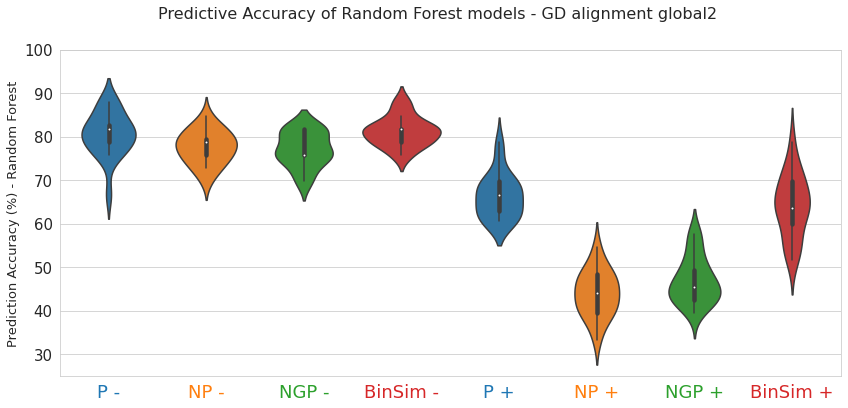

In [14]:
column_names = ['P -', 'NP -', 'NGP -', 'BinSim -', 'P +', 'NP +', 'NGP +', 'BinSim +']

# Violin plot of the distribution of the predictive accuracy (in %) across the iterations of randomly sampled folds for each 
# differently-treated dataset.

cols2keep = [col for col in accuracies.columns if 'global2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = sns.color_palette('tab10', 4)
    colors.extend(colors)

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize=13)
    plt.ylim([25,100])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of Random Forest models - GD alignment global2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)

In [15]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 P,0.806061,0.050516,GDg2-,P
GD_neg_global2 NP,0.775758,0.038582,GDg2-,NP
GD_neg_global2 NGP,0.771212,0.039906,GDg2-,NGP
GD_neg_global2 BinSim,0.812121,0.033485,GDg2-,BinSim
GD_pos_global2 P,0.663636,0.050992,GDg2+,P
GD_pos_global2 NP,0.439394,0.052486,GDg2+,NP
GD_pos_global2 NGP,0.469697,0.052486,GDg2+,NGP
GD_pos_global2 BinSim,0.640909,0.071084,GDg2+,BinSim
GD_neg_class2 P,0.968182,0.036090,GDc2-,P
GD_neg_class2 NP,0.837879,0.029942,GDc2-,NP


#### Average Predictive Accuracies of Random Forest models

Error bars were built based on the standard deviation of the predictive accuracies.

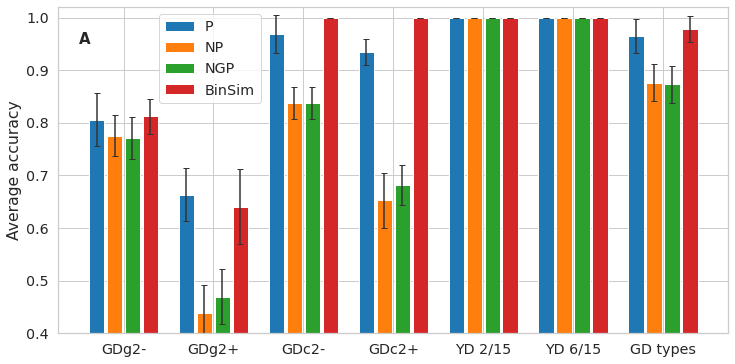

In [16]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.3):
        f, ax = plt.subplots(1, 1, figsize=(12, 6))
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.17  # the width of the bars
        for i, treatment in enumerate(('P', 'NP', 'NGP', 'BinSim')):
            acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
            offset = - 0.3 + i * 0.2
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        ax.text(-0.5, 0.95, 'A', weight='bold', fontsize=15)
        ax.legend(loc='upper left', bbox_to_anchor=(0.14, 1))
        #f.savefig('paperimages/RF_performance.pdf' , dpi=200)
        #f.savefig('paperimages/RF_performance.png' , dpi=600)

### Important feature analysis - Random Forest

Importance metric - Gini Importance

The 2% most important features in each case were taken and the median of the occurrence of those features in samples (`# samples`), the median of the occurrence of those features in groups/varieties (`# classes`), the ratio between these two measures (`samples/classes`, has a maximum of 3) and the number of features chosen (`# top 2%`) were calculated. Furthermore, 
the percentage of the models explained by the 2% of the most important features (`% model explained`) and the number of times the importance of the most important feature is greater than the average importance of a feature in each case (`top feat / average`).

Swarmplot were also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [17]:
# Function to calculate the characteristics of a the top 'fraction' of features based on their importance (by a certain metric).
def compute_RF_top_feat_stats(name, resdict, fraction=0.02):
    imp_features = resdict['important_features']

    original_data = datasets[resdict['dskey']]['data']
    labels = datasets[resdict['dskey']]['target']

    ratio = []
    nsamples = []
    n_groups = []
    feature_locs = []

    n_features = original_data.shape[1]

    # Top 2% (rounded)
    number = round(fraction * n_features)
    # Calculate, store how many times most important
    # feature is more important than the average importance
    
    resdict['top feature fold importance'] = imp_features[0][1]/(1/n_features)

    top_features = imp_features[:number]
    
    resdict['number top features'] = number
    
    s = 0 # Count the % explained - add for each feature
    for loc, importance in top_features: # Iterate for only the number of features considered as important

        s += importance * 100 

         # fetch feature form unprocessed data
        column = original_data.iloc[:, loc]
        feature_notnull = column.notnull()

        # Count how many samples the feature appears in
        feature_nsamples = feature_notnull.sum()
        nsamples.append(feature_nsamples) 

        # Count how many groups the feature appears in
        group_occurrence = {}        
        for n, f in enumerate(feature_notnull):
            if f == True:
                group_occurrence[labels[n]] = 1
        feature_ngroups = sum(list((group_occurrence.values())))
        n_groups.append(feature_ngroups)

        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(feature_nsamples/feature_ngroups)

        # Store identification of feature
        feature_locs.append(loc)

    resdict['% top features explanation'] = s

    resdict.update({'n samples': nsamples, 'n groups': n_groups, 'ratios':ratio, 'top features': feature_locs})

for name, resdict in RF_all.items():
    compute_RF_top_feat_stats(name, resdict)


Important Features Characteristics

In [18]:
df_RF_stats = {'# samples': {name: np.median(RF_all[name]['n samples']) for name in RF_all},
               '# classes': {name: np.median(RF_all[name]['n groups']) for name in RF_all},
               'samples/classes': {name: np.median(RF_all[name]['ratios']) for name in RF_all},
               '# top 2%': {name: np.median(RF_all[name]['number top features']) for name in RF_all},
               '% model explained': {name: np.median(RF_all[name]['% top features explanation']) for name in RF_all},
               'top feat / average':{name: np.median(RF_all[name]['top feature fold importance']) for name in RF_all}}
df_RF_stats = pd.DataFrame(df_RF_stats)

df_RF_stats

,# samples,# classes,samples/classes,# top 2%,% model explained,top feat / average
GD_neg_global2 P,29.0,10.0,2.900000,73.0,7.894343,5.127950
GD_neg_global2 NP,9.0,4.0,2.000000,73.0,5.444991,4.187266
GD_neg_global2 NGP,9.0,4.0,2.250000,73.0,5.463395,3.947873
GD_neg_global2 BinSim,5.0,2.0,2.500000,73.0,7.440459,6.375414
GD_pos_global2 P,30.0,11.0,2.900000,141.0,15.244840,12.363043
GD_pos_global2 NP,19.0,8.0,2.500000,141.0,9.003613,7.161073
GD_pos_global2 NGP,18.0,8.0,2.555556,141.0,9.309094,11.145439
GD_pos_global2 BinSim,7.0,3.0,2.500000,141.0,11.189737,9.530237
GD_neg_class2 P,29.0,10.0,3.000000,61.0,6.176217,3.929253
GD_neg_class2 NP,7.0,3.0,2.666667,61.0,5.024792,3.461276


Occurences by samples and by classes

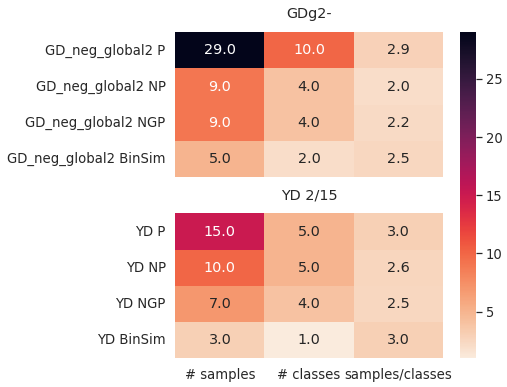

In [19]:
dist_only = df_RF_stats[['# samples', '# classes', 'samples/classes']]
line = pd.DataFrame([], columns=dist_only.columns, index=[''])
display_df = pd.concat([dist_only.iloc[:4], line, dist_only.iloc[16:20]])
#display_df

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(figsize=(6,6))
        hm = sns.heatmap(display_df, annot=True, fmt='.1f', ax=ax, cmap = sns.cm.rocket_r)
        bottom, top = ax.get_ylim()

        plt.text(1.5,-0.5,'GDg2-',horizontalalignment='center', verticalalignment='center')
        plt.text(1.5,4.5,'YD 2/15',horizontalalignment='center', verticalalignment='center')
plt.show()

### Plotting swarmplots with the distributions of samples important features appear in

#### Swarmplot for the GDg2- and YD 2/15 data sets

GDg2- sample medians
GD_neg_global2 P         29.0
GD_neg_global2 NP         9.0
GD_neg_global2 NGP        9.0
GD_neg_global2 BinSim     5.0
dtype: float64

 YD 2/15- sample medians
YD P         15.0
YD NP        10.0
YD NGP        7.0
YD BinSim     3.0
dtype: float64


C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


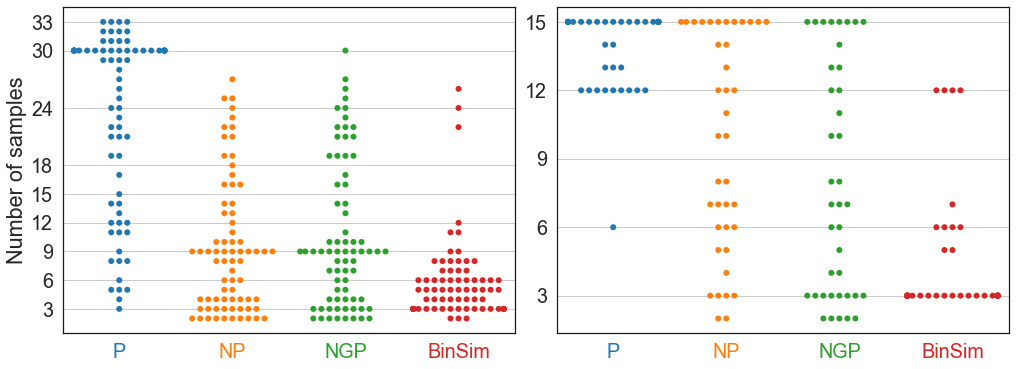

In [20]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.8):
        f, (axl, axr) = plt.subplots(1,2, figsize=(14,5), constrained_layout=True)
        colors = sns.color_palette('tab10', 4)
        tl = ticker.FixedLocator([3, 6, 9, 12, 15, 18, 24, 30, 33])
        
        df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='GD_neg_global2'}
        df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
        print('GDg2- sample medians')
        print(df_RF_sample_dist.median())
        sns.swarmplot(data=df_RF_sample_dist, size=6, palette=colors, ax=axl)

        axl.set(xticklabels = ['P','NP','NGP','BinSim'])
        axl.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(axl.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axl.yaxis.set_major_locator(tl)
        for spine in axl.spines.values():
            spine.set_edgecolor('0.1')

        df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='YD'}
        df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
        print('\n YD 2/15- sample medians')
        print(df_RF_sample_dist.median())
        sns.swarmplot(data=df_RF_sample_dist, size=6, palette=colors, ax=axr)

        axr.set(xticklabels = ['P','NP','NGP','BinSim'])
        #axr.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(axr.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axr.yaxis.set_major_locator(tl)
        for spine in axr.spines.values():
            spine.set_edgecolor('0.1')

        #title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        #GDg2-"""
        title = ''

        #f.suptitle(title, fontsize=14)
        f.savefig('paperimages/fi_dist_RF.png', dpi=600)
        f.savefig('paperimages/fi_dist_RF.pdf', dpi=200)

        plt.show()

Different swarmplots for different data sets with different image parameters

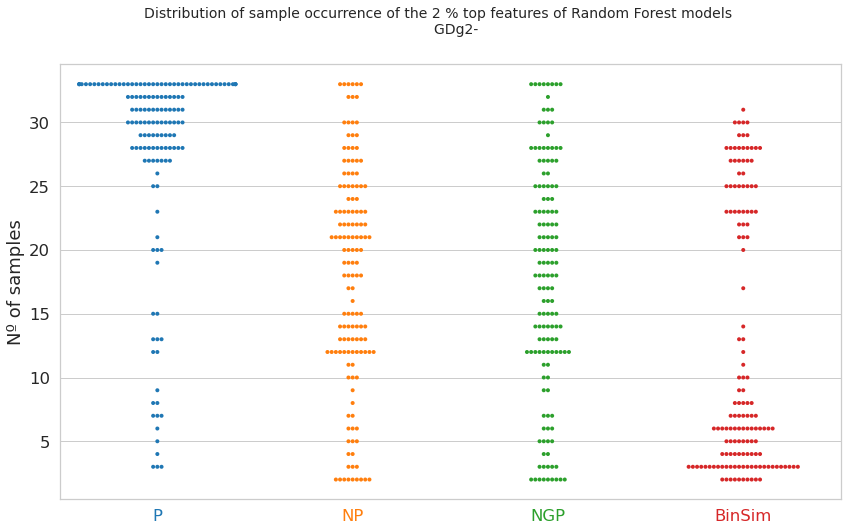

In [21]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='GD_pos_global2'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)

# Plot the swarm plot and adjust parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        GDg2-"""

        f.suptitle(title, fontsize=14)

plt.show()

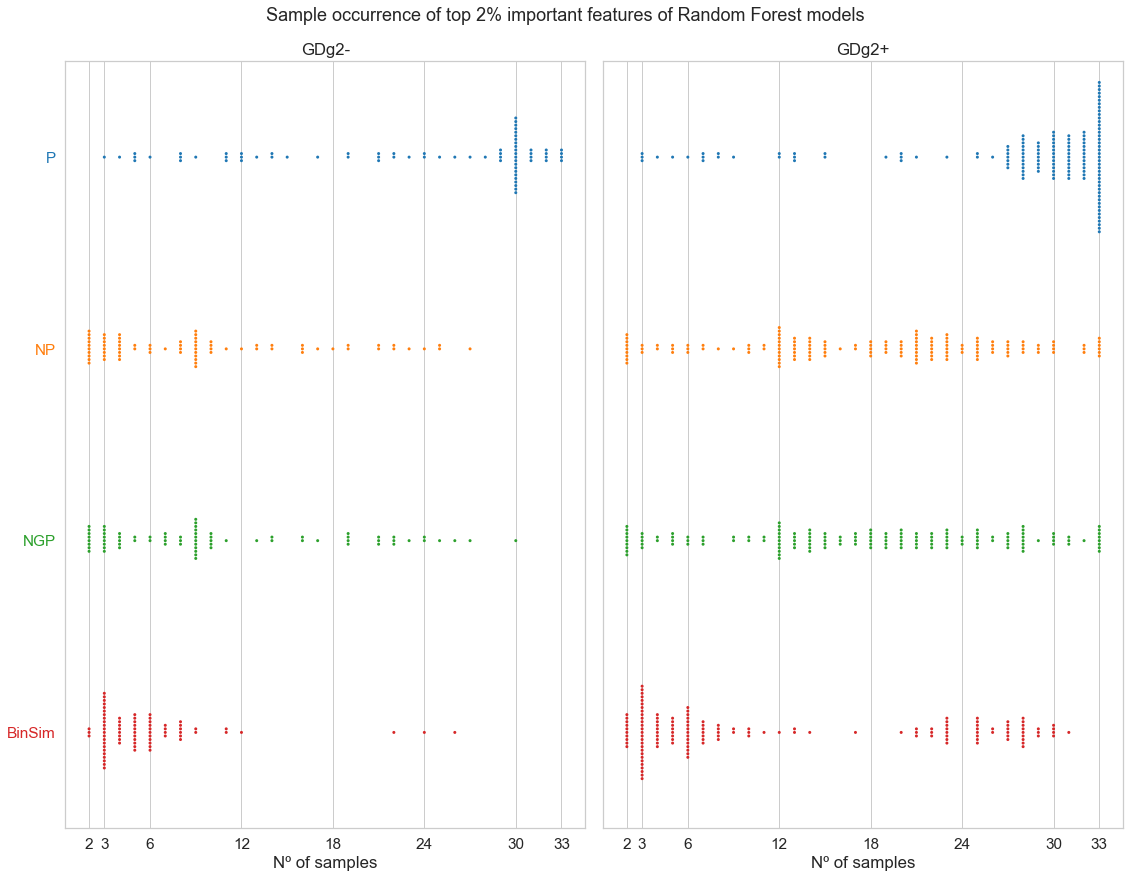

In [22]:
from matplotlib import ticker

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(16,12.5))

        colors = sns.color_palette('tab10', 4)
        tl = ticker.FixedLocator([2, 3, 6, 12, 18, 24, 30, 33])
        
        to_plot = [name for name in RF_all if RF_all[name]['dskey']=='GD_neg_global2']
        df_RF_sample_dist = {RF_all[name]['treatment']: RF_all[name]['n samples'] for name in to_plot}
        df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
        # Plot the swarm plot and adjust parameters
        sns.swarmplot(data=df_RF_sample_dist, size=3, palette=colors, orient='h', ax=axl)
        title = "GDg2-"
        axl.set(xlabel='Nº of samples', title=title)
        for ticklabel, tickcolor in zip(axl.get_yticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axl.xaxis.set_major_locator(tl)
        
        to_plot = [name for name in RF_all if RF_all[name]['dskey']=='GD_pos_global2']
        df_RF_sample_dist = {RF_all[name]['treatment']: RF_all[name]['n samples'] for name in to_plot}
        df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
        
        sns.swarmplot(data=df_RF_sample_dist, size=3, palette=colors, orient='h', ax=axr)
        title = "GDg2+"
        axr.set(xlabel='Nº of samples', yticklabels = [], title=title)
        axr.xaxis.set_major_locator(tl)

        f.suptitle("Sample occurrence of top 2% important features of Random Forest models", fontsize=18)
        plt.tight_layout()

        plt.show()

C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


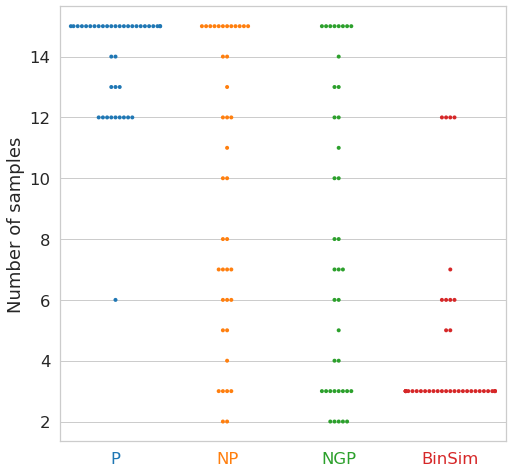

In [23]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='YD'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)

# Plot the swarm plot and adjust parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, ax = plt.subplots(figsize=(8,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        YD 2/15"""

        #f.suptitle(title, fontsize=14)
        f.savefig('paperimages/fi_distYD_RF.png', dpi=600)
        f.savefig('paperimages/fi_distYD_RF.pdf', dpi=200)

plt.show()

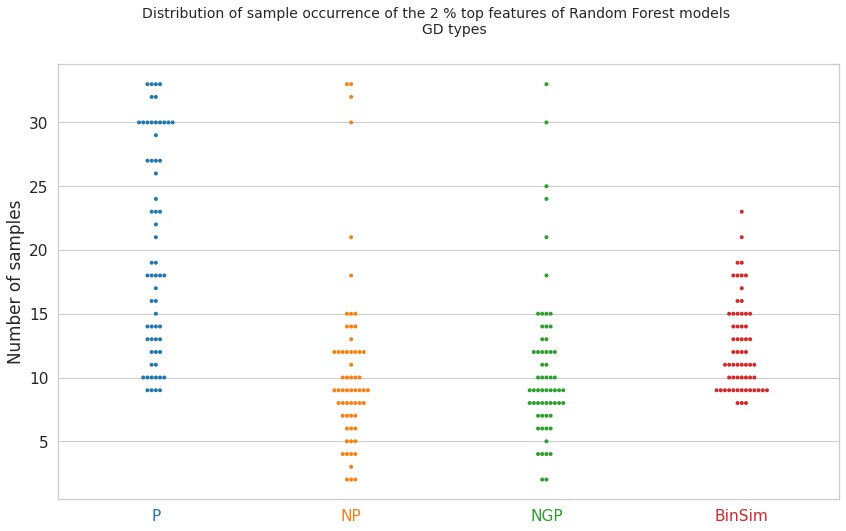

In [24]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='vitis_types'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)

# Plot the swarm plot and adjust parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = f"""Distribution of sample occurrence of the 2 % top features of Random Forest models
        {datasets[RF_all[name]['dskey']]['name']}"""

        f.suptitle(title, fontsize=14)

plt.show()

### Overlaps of Features considered as Important to build each differently-treated data set - Random Forest

For each benchmark data set, 4 differently-treated data sets were obtained. These each have their own set of important features (top 2% chosen). The following cells compute the number of features in common between those sets (common in all 4, in each possible set of 3 and 2 and exclusive to only 1) for each benchmark data set.

The features appearing in all 4 are not taken into account for counting the features that appear in each set of 3 or sets of 2, and the same for the features in sets of 3 not appearing in the counts for the sets of 2. This is made so all values can be directly put into Venn Diagram without the need for further calculation.

In [25]:
# Since we only want counts, let's use the list of locs for the important features
features_as_sets = {name:{} for name in datasets}
for name, rf_dict in RF_all.items():
    features_as_sets[rf_dict['dskey']][rf_dict['treatment']] = set(RF_all[name]['top features'])

def features_overlap(features):
    """Compute Venn diagram counts. Expects a dict of sets as input."""
    counts = {}
    # union
    union = list(itertools.accumulate(features.values(), set.union))[-1]
    counts['union'] = len(union)
 
    # exclusive
    for i in features:
        fi = features[i]
        for j in features:
            if j == i:
                continue
            fi = fi - features[j]
        counts[(i,)] = len(fi)
    # pairwise
    for i,j in itertools.combinations(features,2):
        tuplecomb = (i,j)
        fi = set.intersection(features[i], features[j])
        for others in features:
            if others in tuplecomb:
                continue
            fi = fi - features[others]
        counts[tuplecomb] = len(fi)
    # overlap of 3
    for i,j, k in itertools.combinations(features,3):
        tuplecomb = (i,j, k)
        fi = set.intersection(features[i], features[j], features[k])
        for others in features:
            if others in tuplecomb:
                continue
            fi = fi - features[others]
        counts[tuplecomb] = len(fi)
    # present in all
    intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
    counts[tuple(features.keys())] = len(intersection)
    
    # Assuming respect for the order insertion in a dict...
    assert sum(list(counts.values())[1:]) == counts['union']
    
    return counts

def print_overlaps(counts):
    for k in counts:
        if k == 'union':
            print('Nº of features across all (union):', counts[k])   
        elif len(k) == 1:
            print('exclusive to', k[0], counts[k])
        else:
            print('Number of features in', k, counts[k])

In [26]:
# Test for GDg2-
features = features_as_sets['GD_neg_global2']

counts = features_overlap(features)
print_overlaps(counts)

Nº of features across all (union): 236
exclusive to P 58
exclusive to NP 38
exclusive to NGP 39
exclusive to BinSim 54
Number of features in ('P', 'NP') 0
Number of features in ('P', 'NGP') 3
Number of features in ('P', 'BinSim') 7
Number of features in ('NP', 'NGP') 21
Number of features in ('NP', 'BinSim') 5
Number of features in ('NGP', 'BinSim') 2
Number of features in ('P', 'NP', 'NGP') 4
Number of features in ('P', 'NP', 'BinSim') 1
Number of features in ('P', 'NGP', 'BinSim') 0
Number of features in ('NP', 'NGP', 'BinSim') 4
Number of features in ('P', 'NP', 'NGP', 'BinSim') 0


In [27]:
for dskey in datasets:
    print(f'\nFeature overlap for dataset {datasets[dskey]["name"]} -----------------------')
    features = features_as_sets[dskey]
    counts = features_overlap(features)
    print_overlaps(counts)


Feature overlap for dataset GDg2- -----------------------
Nº of features across all (union): 236
exclusive to P 58
exclusive to NP 38
exclusive to NGP 39
exclusive to BinSim 54
Number of features in ('P', 'NP') 0
Number of features in ('P', 'NGP') 3
Number of features in ('P', 'BinSim') 7
Number of features in ('NP', 'NGP') 21
Number of features in ('NP', 'BinSim') 5
Number of features in ('NGP', 'BinSim') 2
Number of features in ('P', 'NP', 'NGP') 4
Number of features in ('P', 'NP', 'BinSim') 1
Number of features in ('P', 'NGP', 'BinSim') 0
Number of features in ('NP', 'NGP', 'BinSim') 4
Number of features in ('P', 'NP', 'NGP', 'BinSim') 0

Feature overlap for dataset GDg2+ -----------------------
Nº of features across all (union): 382
exclusive to P 89
exclusive to NP 44
exclusive to NGP 41
exclusive to BinSim 79
Number of features in ('P', 'NP') 5
Number of features in ('P', 'NGP') 7
Number of features in ('P', 'BinSim') 13
Number of features in ('NP', 'NGP') 50
Number of features 

## Projection in Latent Structures Discriminant Analysis (PLS-DA)

PLS-DA models were built using the `PLSRegression` of scikit-learn while imposing a prediction decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. The target vectors matrix was made by each different group is made into a column and 1 represents the sample belonging to that group (0 means it doesn't belong) with one-hot encoding. 

### Optimization - Search for the best number of components of PLS model

The number of components were optimized by the 1 - PRESS/SS or Q$^2$ (PLS Score) of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares; SS - residual Sum of Squares

Strategy: Build PLS-DA with different number of components and extract the PLS score (inverse relation to the mean-squared error ) of the models estimated with stratified k-fold cross-validation. Observe at which point (number of components) the PLS Score starts approaching a "stable maximum value". This was done using the `optim_PLSDA_n_components` from multianalysis.py (see details there).

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

**Note**: GD data sets here are only shown until a maximum of 10 components for visualization purposes. This optimization was made with a higher maximum number of components than 10, where we observed than 11 components was a good choice for these data sets.

In [28]:
GENERATE = False #False

In [29]:
%%capture --no-stdout
if GENERATE:
    # above is to supress PLS warnings

    # NOTE: for debugging
    max_comp=10
    # otherwise
    #max_comp=50

    # Store Results
    PLS_optim = {}

    # Build and extract metrics from models build with different number of components by using the optim_PLS function.
    for name, dataset in datasets.items():
        for treatment in ('P', 'NP', 'NGP', 'BinSim'):
            print(f'Fitting PLS-DA model for {name} with treatment {treatment}', end=' ...')
            plsdaname = name + ' ' + treatment
            PLS_optim[plsdaname] = {'dskey': name, 'dataset':dataset['name'], 'treatment':treatment}
            n_fold = 5 if name == 'vitis_types' else 3
            optim = ma.optim_PLSDA_n_components(dataset[treatment], dataset['target'],
                                                max_comp=max_comp, n_fold=n_fold).CVscores
            PLS_optim[plsdaname]['CV_scores'] = optim
            print(f'done')
    fname = 'paperimages/PLSDA_optim.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(PLS_optim, write_file)


In [30]:
fname = 'paperimages/PLSDA_optim.json'
with open(fname, "r", encoding='utf8') as read_file:
    PLS_optim = json.load(read_file)

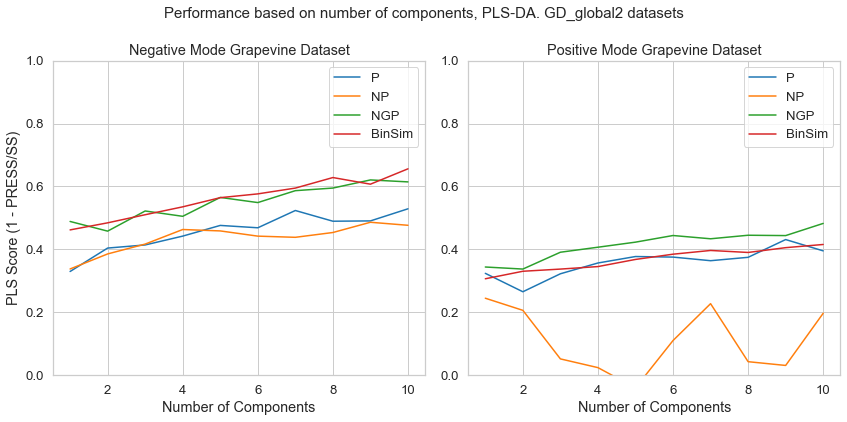

In [31]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (12,6))
        plt.suptitle('Performance based on number of components, PLS-DA. GD_global2 datasets', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'GD_neg_global2':
                # Negative Grapevine Dataset
                axl.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axl.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Negative Mode Grapevine Dataset')
                axl.legend()
                axl.set_ylim([0, 1])

            if data['dskey'] == 'GD_pos_global2':
                # Positive Grapevine Dataset
                axr.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axr.set(xlabel='Number of Components',
                        ylabel='',
                        title='Positive Mode Grapevine Dataset')
                axr.legend()
                axr.set_ylim([0, 1])
        plt.tight_layout()
        plt.show()

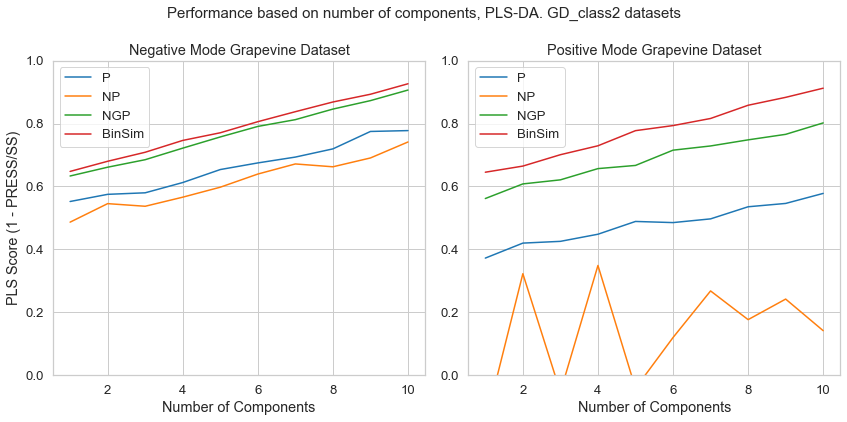

In [32]:
# Plotting the results and adjusting plot parameters


with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (12,6))
        plt.suptitle('Performance based on number of components, PLS-DA. GD_class2 datasets', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'GD_neg_class2':
                # Negative Grapevine Dataset
                axl.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axl.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Negative Mode Grapevine Dataset')
                axl.legend()
                axl.set_ylim([0, 1])

            if data['dskey'] == 'GD_pos_class2':
                # Positive Grapevine Dataset
                axr.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axr.set(xlabel='Number of Components',
                        ylabel='',
                        title='Positive Mode Grapevine Dataset')
                axr.legend()
                axr.set_ylim([0, 1])
        plt.tight_layout()
        plt.show()

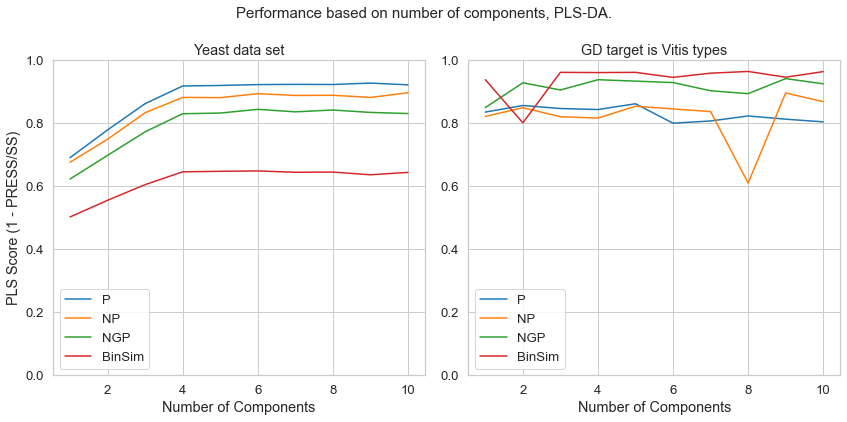

In [33]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (12,6))
        plt.suptitle('Performance based on number of components, PLS-DA.', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'YD':
                # Negative Grapevine Dataset
                axl.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axl.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Yeast data set')
                axl.legend()
                axl.set_ylim([0, 1])

            if data['dskey'] == 'vitis_types':
                # Positive Grapevine Dataset
                axr.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axr.set(xlabel='Number of Components',
                        ylabel='',
                        title='GD target is Vitis types')
                axr.legend()
                axr.set_ylim([0, 1])
        plt.tight_layout()
        plt.show()

For the YD 2/15, YD 6/15 and GD types, PLS-DA models are going to be built with 6 components.

For all the other GD data sets (GDg2-, GDg2+, GDc2-, GDc2+), PLS-DA models are going to be built with 11 components (results for the optimization with more than 10 components are not shown here).

### PLS-DA models

PLS-DA models were built with the `PLSRegression` (PLS2 algorithm used) from scikit-learn using the `PLSDA_model_CV` from multianalysis.py (each step explained better there).

The prediction decision rule used was to choose the group corresponding to the maximum value in the predicted regression vector - ypred (one value for each group, PLS output) - obtained for a test sample - naive MAX rule. The target vectors matrix was made by each different group is made into a column and 1 represents the sample belonging to that group (0 means it doesn't belong) with one-hot encoding. 

This function performs n iterations to randomly sample the folds in k-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset. 

It then stores predictive accuracy of the models, the Q$^2$ score (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to a chosen feature importance metric.

The function allows the choice of 3 different feature importance metrics (feat_type):

- **VIP (Variable Importance/Influence in Projection)** - used in the paper (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [34]:
%%capture --no-stdout
if GENERATE:
    PLSDA_all = {}

    # NOTE: for debugging
    iter_num=10 #20
    # otherwise
    #iter_num=200

    # For each differently-treated dataset, fit PLS-DA models on n randomly sampled folds (for stratified cross-validation)
    for name, dataset in datasets.items():
        for treatment in ('P', 'NP', 'NGP', 'BinSim'):
            print(f'Fitting a PLS-DA model to {name} with treatment {treatment}', end=' ...')
            plsdaname = name + ' ' + treatment
            PLSDA_all[plsdaname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            n_comp = 11 if name.startswith('GD') else 6
            n_fold = 5 if name == 'vitis_types' else 3
            fit = ma.PLSDA_model_CV(dataset[treatment], dataset['target'],
                                    n_comp=n_comp, n_fold=n_fold,
                                    iter_num=iter_num,
                                    feat_type='VIP')
            PLSDA_all[plsdaname].update(fit)
            print(f'done')     
    PLSDA_all
    fname = 'paperimages/PLSDA_all.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(PLSDA_all, write_file)

#### Results of the PLS-DA - Performance (Predictive Accuracy) 

In [35]:
# Accuracy across iterations
fname = 'paperimages/PLSDA_all.json'
with open(fname, "r", encoding='utf8') as read_file:
    PLSDA_all = json.load(read_file)

accuracies = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracies

,GD_neg_global2 P,GD_neg_global2 NP,GD_neg_global2 NGP,GD_neg_global2 BinSim,GD_pos_global2 P,GD_pos_global2 NP,GD_pos_global2 NGP,GD_pos_global2 BinSim,GD_neg_class2 P,GD_neg_class2 NP,...,YD NGP,YD BinSim,YD2 P,YD2 NP,YD2 NGP,YD2 BinSim,vitis_types P,vitis_types NP,vitis_types NGP,vitis_types BinSim
0,0.727273,0.727273,0.878788,0.818182,0.666667,0.666667,0.848485,0.787879,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.0,1.0
1,0.696970,0.787879,0.787879,0.848485,0.787879,0.696970,0.878788,0.848485,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.939394,1.0,1.0
2,0.727273,0.757576,0.818182,0.787879,0.727273,0.787879,0.848485,0.878788,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.939394,1.0,1.0
3,0.727273,0.666667,0.757576,0.848485,0.757576,0.727273,0.787879,0.787879,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.0,1.0
4,0.727273,0.696970,0.787879,0.848485,0.757576,0.757576,0.818182,0.818182,0.939394,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.969697,1.0,1.0
5,0.727273,0.696970,0.757576,0.787879,0.696970,0.757576,0.818182,0.787879,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.0,1.0
6,0.818182,0.757576,0.818182,0.878788,0.757576,0.696970,0.787879,0.727273,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.0,1.0
7,0.757576,0.696970,0.818182,0.848485,0.666667,0.696970,0.818182,0.787879,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.0,1.0
8,0.757576,0.787879,0.757576,0.878788,0.696970,0.727273,0.818182,0.818182,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.939394,1.0,1.0
9,0.727273,0.727273,0.757576,0.909091,0.757576,0.696970,0.848485,0.848485,0.939394,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,0.909091,0.939394,1.0,1.0


#### Distribution for GDg2- and GDg2+ and then for GDc2- and GDc2+

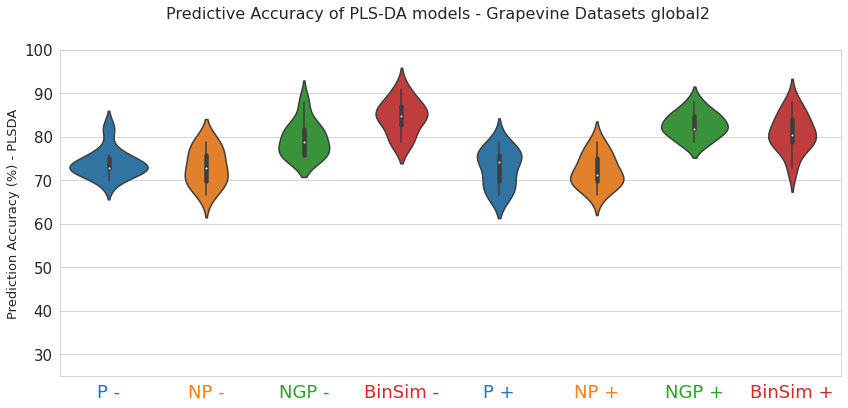

In [36]:
column_names = ['P -', 'NP -', 'NGP -', 'BinSim -', 'P +', 'NP +', 'NGP +', 'BinSim +']
# Violin plot of the distribution of the predictive accuracy (in %) across 100 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.

cols2keep = [col for col in accuracies.columns if 'global2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = sns.color_palette('tab10', 4)
    colors.extend(colors)

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - PLSDA', fontsize=13)
    plt.ylim([25,100])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of PLS-DA models - Grapevine Datasets global2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)

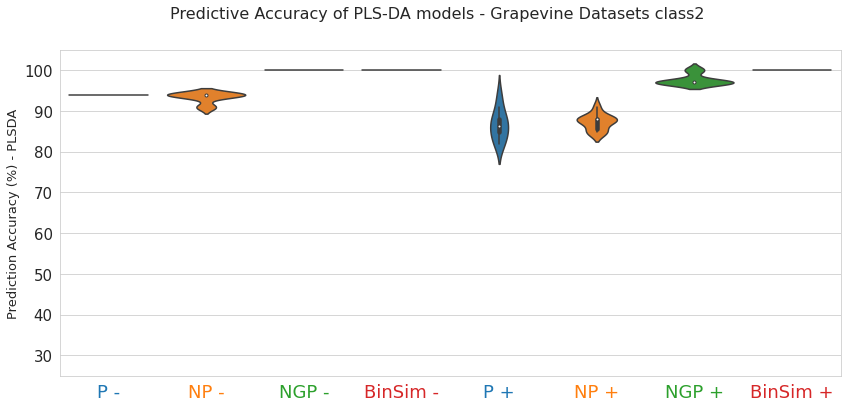

In [37]:
column_names = ['P -', 'NP -', 'NGP -', 'BinSim -', 'P +', 'NP +', 'NGP +', 'BinSim +']
# Violin plot of the distribution of the predictive accuracy (in %) across the iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.

cols2keep = [col for col in accuracies.columns if 'class2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = sns.color_palette('tab10', 4)
    colors.extend(colors)

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - PLSDA', fontsize=13)
    plt.ylim([25,105])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of PLS-DA models - Grapevine Datasets class2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)

In [38]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all],
                                       treatment=[PLSDA_all[name]['treatment'] for name in PLSDA_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 P,0.739394,0.032575,GDg2-,P
GD_neg_global2 NP,0.730303,0.041525,GDg2-,NP
GD_neg_global2 NGP,0.793939,0.039896,GDg2-,NGP
GD_neg_global2 BinSim,0.845455,0.038990,GDg2-,BinSim
GD_pos_global2 P,0.727273,0.042855,GDg2+,P
GD_pos_global2 NP,0.721212,0.037251,GDg2+,NP
GD_pos_global2 NGP,0.827273,0.028748,GDg2+,NGP
GD_pos_global2 BinSim,0.809091,0.042974,GDg2+,BinSim
GD_neg_class2 P,0.939394,0.000000,GDc2-,P
GD_neg_class2 NP,0.933333,0.012777,GDc2-,NP


#### Average Predictive Accuracies of PLS-DA models

Error bars were built based on the standard deviation of the predictive accuracies.

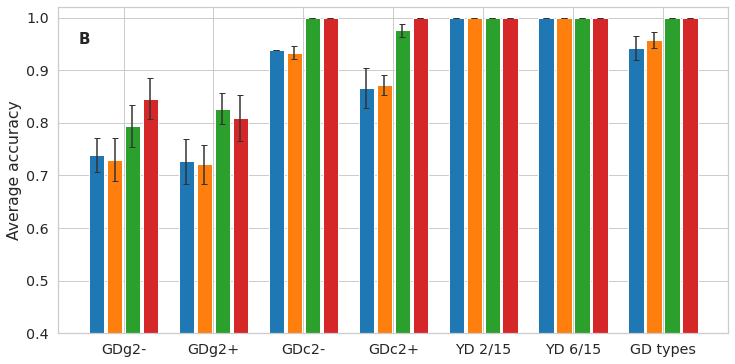

In [39]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.3):
        f, ax = plt.subplots(1, 1, figsize=(12, 6))
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.17  # the width of the bars
        for i, treatment in enumerate(('P', 'NP', 'NGP', 'BinSim')):
            acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
            offset = - 0.3 + i * 0.2
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        ax.text(-0.5, 0.95, 'B', weight='bold', fontsize=15)
        #ax.legend(loc='upper left', bbox_to_anchor=(0.12, 1))
        #f.savefig('paperimages/PLSDA_performance.pdf' , dpi=200)
        #f.savefig('paperimages/PLSDA_performance.png' , dpi=600)

### Accuracy plots for RF and PLS-DA together

In [40]:
accuraciesRF = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracy_stats_RF = pd.DataFrame({'Average accuracy': accuraciesRF.mean(axis=0),
                                  'STD': accuraciesRF.std(axis=0)})
accuracy_stats_RF = accuracy_stats_RF.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])


accuraciesPLSDA = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracy_stats_PLSDA = pd.DataFrame({'Average accuracy': accuraciesPLSDA.mean(axis=0),
                                     'STD': accuraciesPLSDA.std(axis=0)})
accuracy_stats_PLSDA = accuracy_stats_PLSDA.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all],
                                       treatment=[PLSDA_all[name]['treatment'] for name in PLSDA_all])

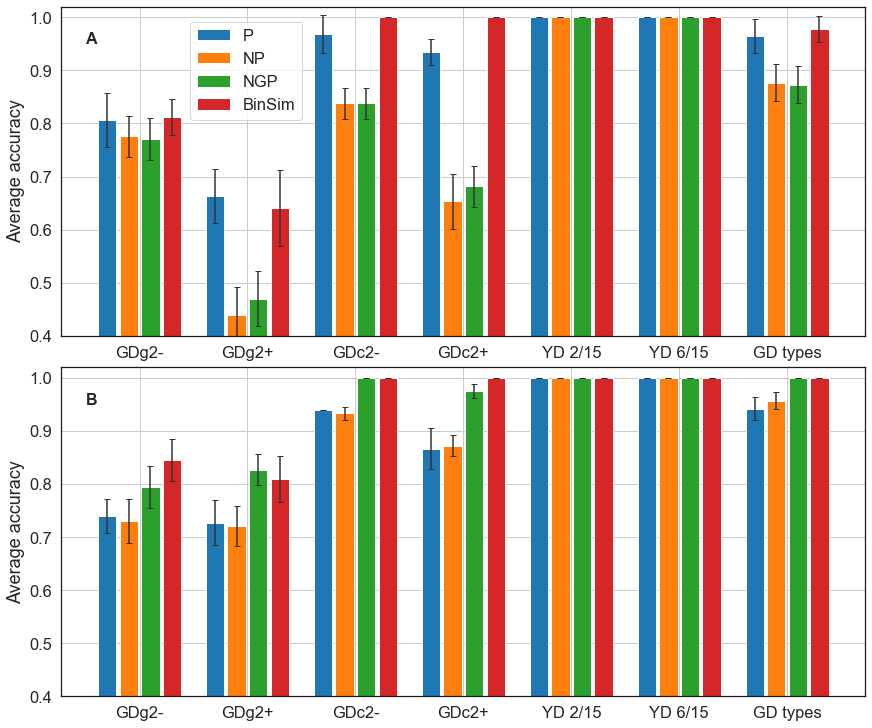

In [41]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, (axu, axl) = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.17  # the width of the bars
        
        for i, treatment in enumerate(('P', 'NP', 'NGP', 'BinSim')):
            acc_treatment = accuracy_stats_RF[accuracy_stats_RF['treatment']==treatment]
            offset = - 0.3 + i * 0.2
            rects = axu.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            axu.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        axu.set_xticks(x)
        axu.set_xticklabels(labels)
        axu.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        axu.text(-0.5, 0.95, 'A', weight='bold', fontsize=16)
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        for i, treatment in enumerate(('P', 'NP', 'NGP', 'BinSim')):
            acc_treatment = accuracy_stats_PLSDA[accuracy_stats_PLSDA['treatment']==treatment]
            offset = - 0.3 + i * 0.2
            rects = axl.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            axl.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        axl.set_xticks(x)
        axl.set_xticklabels(labels)
        axl.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        axl.text(-0.5, 0.95, 'B', weight='bold', fontsize=16)
        for spine in axl.spines.values():
            spine.set_edgecolor('0.1')
        axu.legend(loc='upper left', bbox_to_anchor=(0.15, 0.98))
        plt.show()
        f.savefig('paperimages/supervised_performance.pdf' , dpi=200)
        f.savefig('paperimages/supervised_performance.png' , dpi=600)

### Important feature analysis - PLS-DA

**The same process as it was applied for Random Forest.**

Importance metric - VIP score

The 2% most important features in each case were taken and the median of the occurrence of those features in samples (`# samples`), the median of the occurrence of those features in groups/varieties (`# classes`), the ratio between these two measures (`samples/classes`, has a maximum of 3) and the number of features chosen (`# top 2%`) were calculated. Furthermore, 
the percentage of the models explained by the 2% of the most important features (`% model explained`) and the number of times the importance of the most important feature is greater than the average importance of a feature in each case (`top feat / average`).

Swarmplot were also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [42]:
# Function to calculate the characteristics of a the top 'fraction' of features based on their importance (by a certain metric).
def compute_PLSDA_top_feat_stats(name, resdict, fraction=0.02):
    imp_features = resdict['important_features']

    original_data = datasets[resdict['dskey']]['data']
    labels = datasets[resdict['dskey']]['target']

    ratio = []
    nsamples = []
    n_groups = []
    feature_locs = []

    n_features = original_data.shape[1]

    # Top 2% (rounded)
    number = round(fraction * n_features)
    # Calculate, store how many times most important
    # feature is more important than the average importance
    
    resdict['top feature fold importance'] = imp_features[0][1]

    top_features = imp_features[:number]
    
    resdict['number top features'] = number
    
    s = 0 # Count the % explained - add for each feature
    for loc, importance in top_features: # Iterate for only the number of features considered as important

        s += importance * 100 / n_features

         # fetch feature form unprocessed data
        column = original_data.iloc[:, loc]
        feature_notnull = column.notnull()

        # Count how many samples the feature appears in
        feature_nsamples = feature_notnull.sum()
        nsamples.append(feature_nsamples) 

        # Count how many groups the feature appears in
        group_occurrence = {}        
        for n, f in enumerate(feature_notnull):
            if f == True:
                group_occurrence[labels[n]] = 1
        feature_ngroups = sum(list((group_occurrence.values())))
        n_groups.append(feature_ngroups)

        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(feature_nsamples/feature_ngroups)

        # Store identification of feature
        feature_locs.append(loc)

    resdict['% top features explanation'] = s

    resdict.update({'n samples': nsamples, 'n groups': n_groups, 'ratios':ratio, 'top features': feature_locs})

for name, resdict in PLSDA_all.items():
    compute_PLSDA_top_feat_stats(name, resdict)


Important Feature Characteristics

In [43]:
df_PLSDA_stats = {'# samples': {name: np.median(PLSDA_all[name]['n samples']) for name in PLSDA_all},
               '# classes': {name: np.median(PLSDA_all[name]['n groups']) for name in PLSDA_all},
               'samples/classes': {name: np.median(PLSDA_all[name]['ratios']) for name in PLSDA_all},
               '# top 2%': {name: np.median(PLSDA_all[name]['number top features']) for name in PLSDA_all},
               '% model explained': {name: np.median(PLSDA_all[name]['% top features explanation']) for name in PLSDA_all},
               'top feat / average':{name: np.median(PLSDA_all[name]['top feature fold importance']) for name in PLSDA_all}}
df_PLSDA_stats = pd.DataFrame(df_PLSDA_stats)

df_PLSDA_stats

,# samples,# classes,samples/classes,# top 2%,% model explained,top feat / average
GD_neg_global2 P,15.0,6.0,2.444444,73.0,8.718991,14.245499
GD_neg_global2 NP,13.0,6.0,2.400000,73.0,8.528713,14.916837
GD_neg_global2 NGP,9.0,5.0,2.000000,73.0,3.723343,2.974483
GD_neg_global2 BinSim,14.0,6.0,2.285714,73.0,3.474469,2.034326
GD_pos_global2 P,28.0,10.0,2.909091,141.0,8.112262,12.937350
GD_pos_global2 NP,21.0,9.0,2.727273,141.0,8.185756,13.262917
GD_pos_global2 NGP,21.0,9.0,2.500000,141.0,5.171829,4.728344
GD_pos_global2 BinSim,17.0,8.0,2.333333,141.0,3.934137,2.477469
GD_neg_class2 P,15.0,5.0,2.800000,61.0,8.890386,13.408629
GD_neg_class2 NP,12.0,5.0,2.888889,61.0,8.831563,12.963406


Occurences by samples and by classes

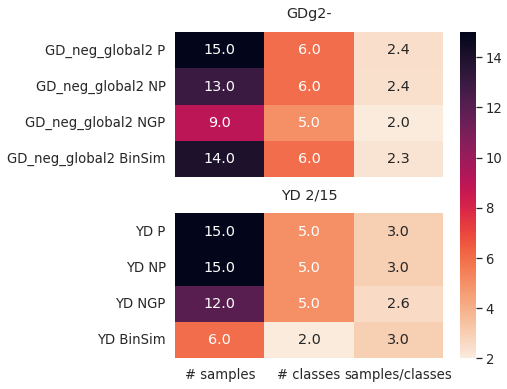

In [44]:
dist_only = df_PLSDA_stats[['# samples', '# classes', 'samples/classes']]
line = pd.DataFrame([], columns=dist_only.columns, index=[''])
display_df = pd.concat([dist_only.iloc[:4], line, dist_only.iloc[16:20]])
#display_df

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(figsize=(6,6))
        hm = sns.heatmap(display_df, annot=True, fmt='.1f', ax=ax, cmap = sns.cm.rocket_r)
        bottom, top = ax.get_ylim()

        plt.text(1.5,-0.5,'GDg2-',horizontalalignment='center', verticalalignment='center')
        plt.text(1.5,4.5,'YD 2/15',horizontalalignment='center', verticalalignment='center')
plt.show()

### Plotting swarmplots with the distributions of samples important features appear in

#### Swarmplot for the GDg2- and YD 2/15 data sets

GDg2- sample medians
GD_neg_global2 P         15.0
GD_neg_global2 NP        13.0
GD_neg_global2 NGP        9.0
GD_neg_global2 BinSim    14.0
dtype: float64

YD 2/15 sample medians
YD P         15.0
YD NP        15.0
YD NGP       12.0
YD BinSim     6.0
dtype: float64


C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 53.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


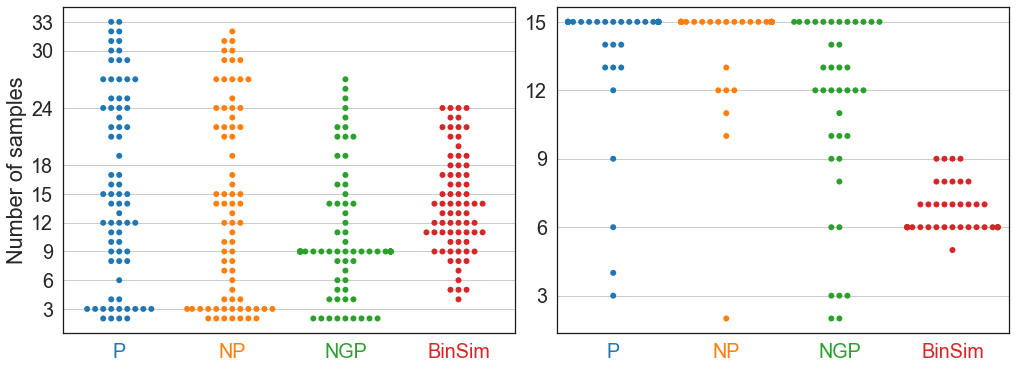

In [45]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.8):
        f, (axl, axr) = plt.subplots(1,2, figsize=(14,5), constrained_layout=True)
        colors = sns.color_palette('tab10', 4)
        tl = ticker.FixedLocator([3, 6, 9, 12, 15, 18, 24, 30, 33])
        
        df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_neg_global2'}
        df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
        print('GDg2- sample medians')
        print(df_PLSDA_sample_dist.median())
        
        sns.swarmplot(data=df_PLSDA_sample_dist, size=6, palette=colors, ax=axl)

        axl.set(xticklabels = ['P','NP','NGP','BinSim'])
        axl.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(axl.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axl.yaxis.set_major_locator(tl)
        for spine in axl.spines.values():
            spine.set_edgecolor('0.1')

        df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='YD'}
        df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
        print('\nYD 2/15 sample medians')
        print(df_PLSDA_sample_dist.median())
        sns.swarmplot(data=df_PLSDA_sample_dist, size=6, palette=colors, ax=axr)

        axr.set(xticklabels = ['P','NP','NGP','BinSim'])
        #axr.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(axr.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axr.yaxis.set_major_locator(tl)
        for spine in axr.spines.values():
            spine.set_edgecolor('0.1')

        #title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        #GDg2-"""
        title = ''

        #f.suptitle(title, fontsize=14)
        f.savefig('paperimages/fi_dist_PLSDA.png', dpi=600)
        f.savefig('paperimages/fi_dist_PLSDA.pdf', dpi=200)
        #plt.savefig('RF-NGD-IF')
        plt.show()

Different swarmplots for different data sets with different image parameters

C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


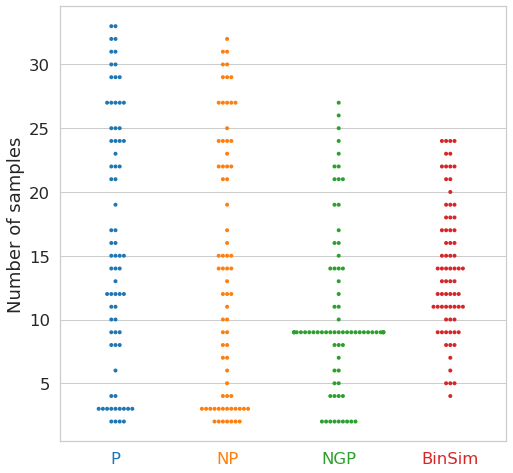

In [46]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_neg_global2'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, ax = plt.subplots(figsize=(8,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of PLS-DA models
        GDg2-"""

        #f.suptitle(title, fontsize=14)
        f.savefig('paperimages/fi_distGDg2neg_PLSDA.png', dpi=600)
        f.savefig('paperimages/fi_distGDg2neg_PLSDA.pdf', dpi=200)

plt.show()

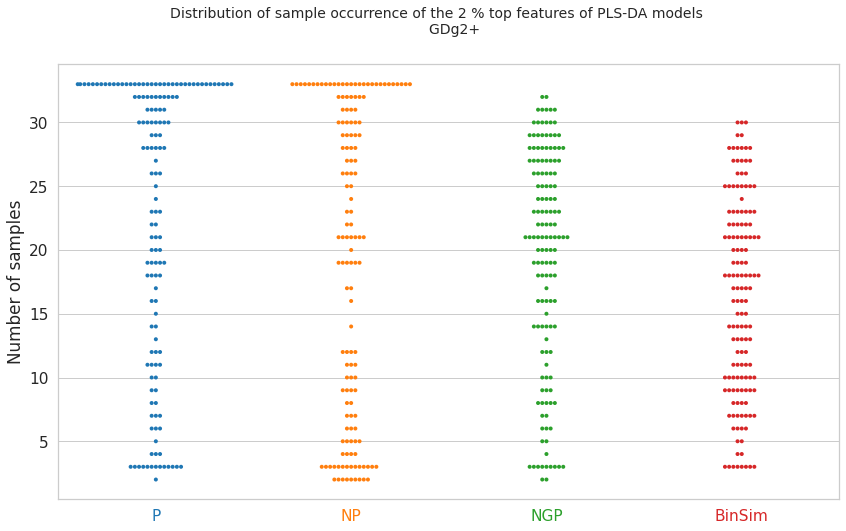

In [47]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_pos_global2'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of PLS-DA models
        GDg2+"""

        f.suptitle(title, fontsize=14)

plt.show()

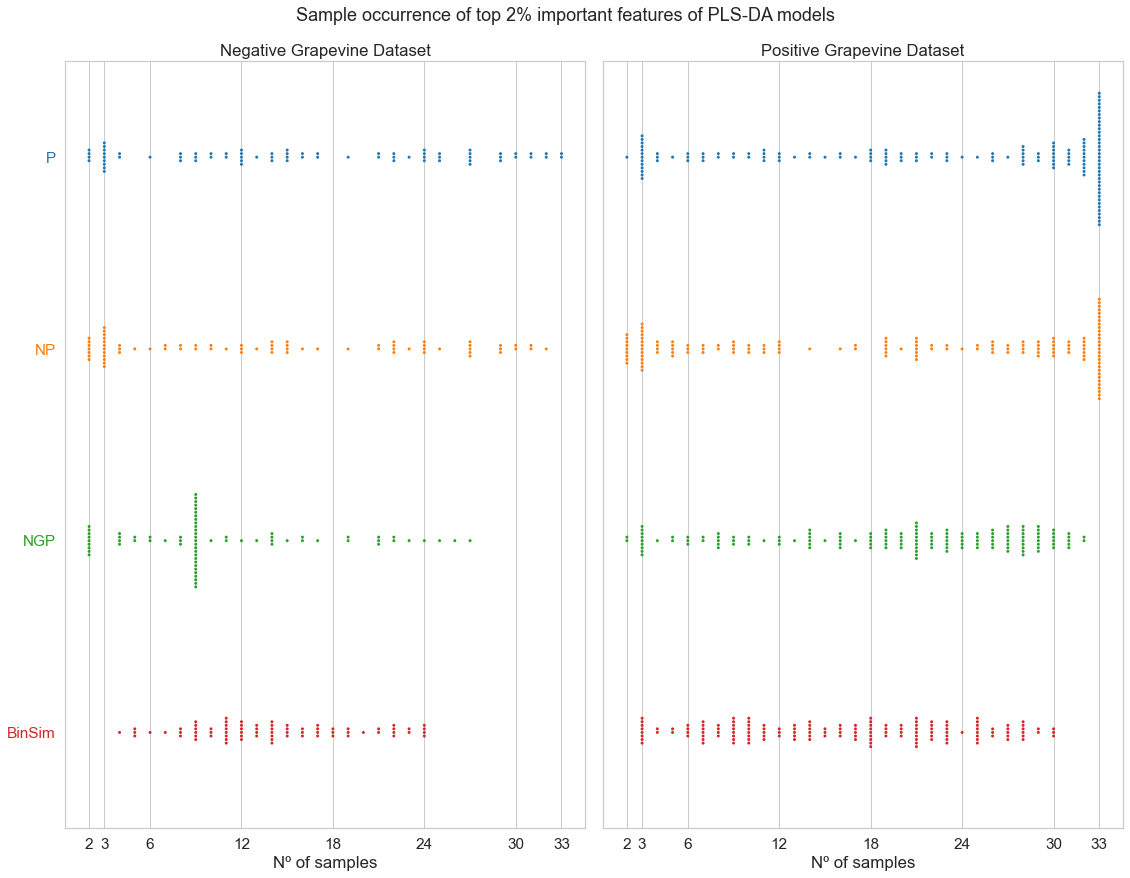

In [48]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(16,12.5))

        colors = sns.color_palette('tab10', 4)
        tl = ticker.FixedLocator([2, 3, 6, 12, 18, 24, 30, 33])
        
        to_plot = [name for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_neg_global2']
        df_sample_dist = {PLSDA_all[name]['treatment']: PLSDA_all[name]['n samples'] for name in to_plot}
        df_sample_dist = pd.DataFrame(df_sample_dist)
        # Plot the swarm plot and adjust parameters
        sns.swarmplot(data=df_sample_dist, size=3, palette=colors, orient='h', ax=axl)
        title = "Negative Grapevine Dataset"
        axl.set(xlabel='Nº of samples', title=title)
        for ticklabel, tickcolor in zip(axl.get_yticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axl.xaxis.set_major_locator(tl)
        
        to_plot = [name for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_pos_global2']
        df_sample_dist = {PLSDA_all[name]['treatment']: PLSDA_all[name]['n samples'] for name in to_plot}
        df_sample_dist = pd.DataFrame(df_sample_dist)
        
        sns.swarmplot(data=df_sample_dist, size=3, palette=colors, orient='h', ax=axr)
        title = "Positive Grapevine Dataset"
        axr.set(xlabel='Nº of samples', yticklabels = [], title=title)
        axr.xaxis.set_major_locator(tl)

        f.suptitle("Sample occurrence of top 2% important features of PLS-DA models", fontsize=18)
        plt.tight_layout()

        plt.show()

C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\a3nf\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


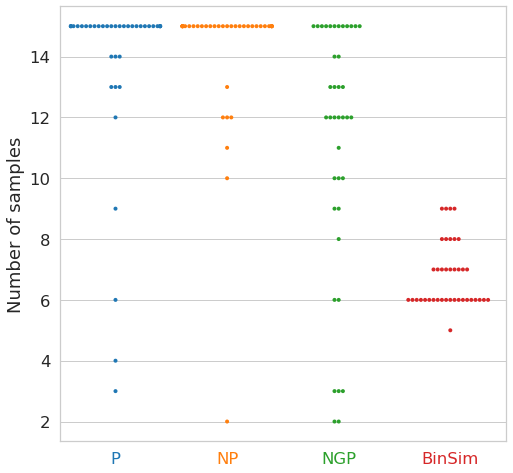

In [49]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='YD'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, ax = plt.subplots(figsize=(8,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Number of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of PLS-DA models
        YD 2/15"""

        #f.suptitle(title, fontsize=14)
        f.savefig('paperimages/fi_distYD_PLSDA.png', dpi=600)
        f.savefig('paperimages/fi_distYD_PLSDA.pdf', dpi=200)

plt.show()

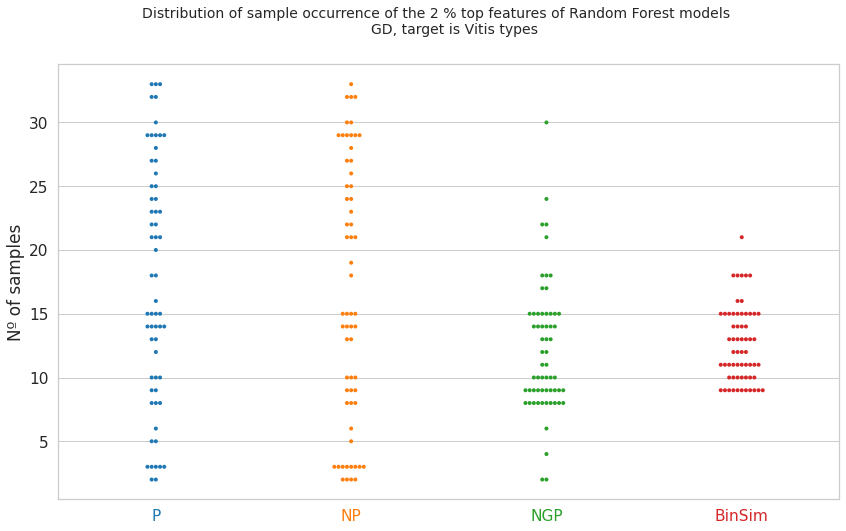

In [50]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='vitis_types'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        GD, target is Vitis types"""

        f.suptitle(title, fontsize=14)

plt.show()

### Overlaps of Features considered as Important to build each differently-treated data set - PLS-DA

For each benchmark data set, 4 differently-treated data sets were obtained. These each have their own set of important features (top 2% chosen). The following cells compute the number of features in common between those sets (common in all 4, in each possible set of 3 and 2 and exclusive to only 1) for each benchmark data set.

The features appearing in all 4 are not taken into account for counting the features that appear in each set of 3 or sets of 2, and the same for the features in sets of 3 not appearing in the counts for the sets of 2. This is made so all values can be directly put into Venn Diagram without the need for further calculation.

In [51]:
# Since we only want counts, let's use the list of locs for the important features
features_as_sets = {name:{} for name in datasets}
for name, plsdict in PLSDA_all.items():
    features_as_sets[plsdict['dskey']][plsdict['treatment']] = set(PLSDA_all[name]['top features'])

In [52]:
for dskey in datasets:
    print(f'\nFeature overlap for dataset {datasets[dskey]["name"]} -----------------------')
    features = features_as_sets[dskey]
    counts = features_overlap(features)
    print_overlaps(counts)


Feature overlap for dataset GDg2- -----------------------
Nº of features across all (union): 183
exclusive to P 9
exclusive to NP 9
exclusive to NGP 40
exclusive to BinSim 48
Number of features in ('P', 'NP') 39
Number of features in ('P', 'NGP') 0
Number of features in ('P', 'BinSim') 2
Number of features in ('NP', 'NGP') 2
Number of features in ('NP', 'BinSim') 0
Number of features in ('NGP', 'BinSim') 10
Number of features in ('P', 'NP', 'NGP') 11
Number of features in ('P', 'NP', 'BinSim') 3
Number of features in ('P', 'NGP', 'BinSim') 1
Number of features in ('NP', 'NGP', 'BinSim') 1
Number of features in ('P', 'NP', 'NGP', 'BinSim') 8

Feature overlap for dataset GDg2+ -----------------------
Nº of features across all (union): 338
exclusive to P 36
exclusive to NP 20
exclusive to NGP 51
exclusive to BinSim 74
Number of features in ('P', 'NP') 64
Number of features in ('P', 'NGP') 0
Number of features in ('P', 'BinSim') 2
Number of features in ('NP', 'NGP') 10
Number of features 

### Example of Sample Projection on the two most important Components/Latent Variables of PLS models built with the full dataset and sample representation 

#### GDg2-, YD and GD types with NGP or BinSim pre-treatment

In [53]:
# Functions for projection
def plot_PLS(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PLS(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')

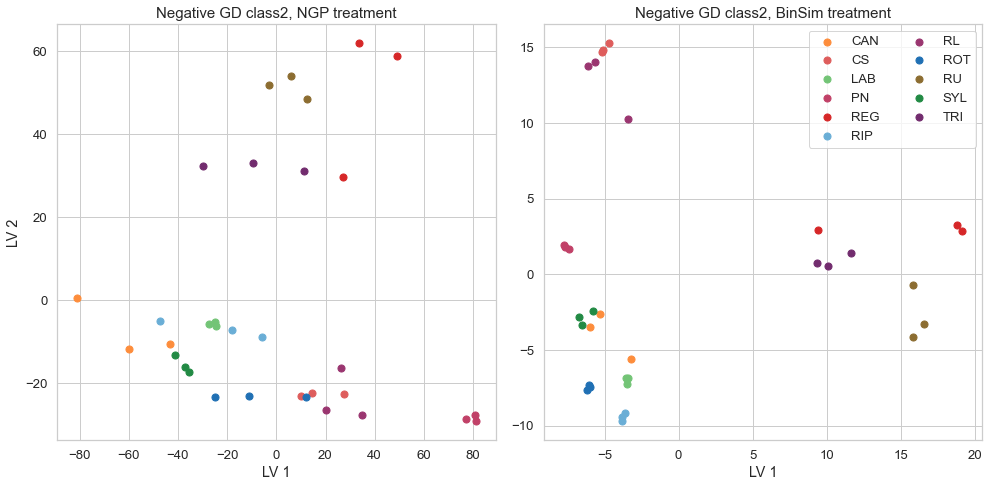

In [54]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['GD_neg_class2']['NGP'],
                                   datasets['GD_neg_class2']['target'], n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(datasets['GD_neg_class2']['BinSim'],
                                     datasets['GD_neg_class2']['target'], n_comp=n_components)

lcolors = datasets['GD_neg_class2']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="Negative GD class2, NGP treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="Negative GD class2, BinSim treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

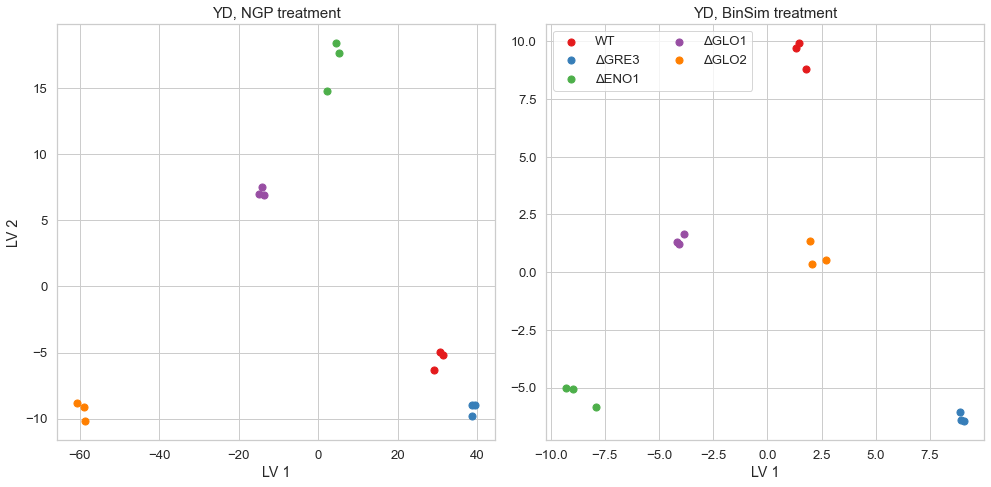

In [55]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['YD']['NGP'],
                                   datasets['YD']['target'], n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(datasets['YD']['BinSim'],
                                     datasets['YD']['target'], n_comp=n_components)

lcolors = datasets['YD']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="YD, NGP treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="YD, BinSim treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper left', ncol=2)               
        plt.tight_layout()
        plt.show()

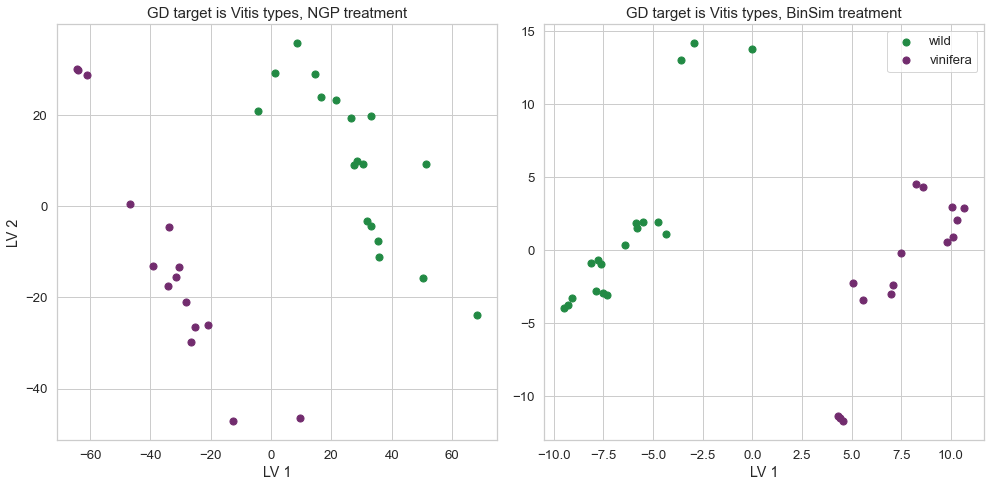

In [56]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['vitis_types']['NGP'],
                                   datasets['vitis_types']['target'], n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(datasets['vitis_types']['BinSim'],
                                     datasets['vitis_types']['target'], n_comp=n_components)

lcolors = datasets['vitis_types']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="GD target is Vitis types, NGP treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="GD target is Vitis types, BinSim treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=1)               
        plt.tight_layout()
        plt.show()